#### ESP32 Stereo Camera Code

In [2]:
import copy
import math

import requests

import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import torch
import torchvision
import torchvision.transforms.functional as tvtf
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights,MaskRCNN_ResNet50_FPN_V2_Weights
%matplotlib inline



#this is the file with auxillary functions. stereo_image_utils.py. Should be in the same
#directory as the notebook
import stereo_image_utils
from stereo_image_utils import get_detections, get_cost, draw_detections, annotate_class2 
from stereo_image_utils import get_horiz_dist_corner_tl, get_horiz_dist_corner_br, get_dist_to_centre_tl, get_dist_to_centre_br

In [17]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
URL_left = "http://192.168.137.86"
URL_right = "http://192.168.137.86"
AWB = True
cnt = 1

#focal length. Pre-calibrated in stereo_image_v6 notebook
fl = 2.043636363636363
tantheta = 0.7648732789907391



In [4]:
weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT

COLOURS = [
    tuple(int(colour_hex.strip('#')[i:i+2], 16) for i in (0, 2, 4))
    for colour_hex in plt.rcParams['axes.prop_cycle'].by_key()['color']
]

In [32]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights)
_ = model.eval()

In [25]:
import cv2
import urllib.request
import numpy as np

req = urllib.request.urlopen('http://192.168.137.86/cam-lo.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'

array([[[107, 117,  87],
        [107, 117,  87],
        [107, 117,  87],
        ...,
        [ 32,  23,  13],
        [ 39,  30,  17],
        [ 43,  34,  21]],

       [[115, 125,  95],
        [115, 125,  95],
        [115, 125,  95],
        ...,
        [ 53,  44,  34],
        [ 58,  49,  36],
        [ 60,  51,  38]],

       [[124, 133, 106],
        [124, 133, 106],
        [124, 133, 106],
        ...,
        [ 72,  63,  53],
        [ 74,  65,  52],
        [ 73,  64,  51]],

       ...,

       [[113, 113,  97],
        [113, 113,  97],
        [113, 113,  97],
        ...,
        [ 32,  32,  32],
        [ 31,  31,  31],
        [ 31,  31,  31]],

       [[113, 113,  97],
        [113, 113,  97],
        [113, 113,  97],
        ...,
        [ 32,  32,  32],
        [ 31,  31,  31],
        [ 31,  31,  31]],

       [[113, 113,  97],
        [113, 113,  97],
        [113, 113,  97],
        ...,
        [ 32,  32,  32],
        [ 31,  31,  31],
        [ 31,  31,  31]]

In [15]:
def load_img(filename):
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [23]:
#capture the images
#cap_left = cv2.VideoCapture("http://192.168.137.86/stream")
#cap_left = cv2.VideoCapture('http://commondatastorage.googleapis.com/gtv-videos-bucket/sample/ForBiggerEscapes.mp4')
#cap_img = load_img("192.168.137.86/cam-lo.jpg")

#cap_right = cv2.VideoCapture("http://192.168.137.41")
# + ":81/stream"
#print(cap_left.isOpened())
print(img.shape, img.dtype)

(240, 320, 3) uint8


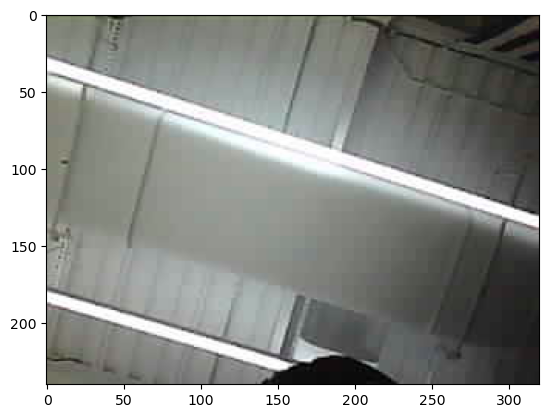

In [27]:
plt.imshow(img)
plt.show()

In [10]:
cv2.imshow('ImageWindow', cap_img)
cv2.waitKey()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [8]:
while(True):
    # Capture frame-by-frame
    ret, frame = cap_left.read()
    #print cap.isOpened(), ret
    if frame is not None:
        # Display the resulting frame
        cv2.imshow('frame',frame)
        # Press q to close the video windows before it ends if you want
        if cv2.waitKey(22) & 0xFF == ord('q'):
            break
    else:
        print ("Frame is None")
        break

# When everything done, release the capture
vcap.release()
cv2.destroyAllWindows()
print ("Video stop")

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [94]:
ret, frame = camera.read("192.168.137.86")
plt.imshow(frame)
plt.title('El Bruno - Office')
plt.show()

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'read'
> Overload resolution failed:
>  - image is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'image'


In [103]:
while True:
    success, img = cap_left.read()

    
    cv2.imshow("Image", img)


cap.release()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [104]:
pip uninstall opencv-python; pip install opencv-python

^C
Note: you may need to restart the kernel to use updated packages.


In [48]:
im = cv2.imread('left_eye',0)
h,w = im.shape[:2]
print(im.shape)
plt.imshow(im,cmap='gray')
plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

In [46]:
#functions for the command handler

def set_resolution(url: str, index: int=1, verbose: bool=False):
    try:
        if verbose:
            resolutions = "10: UXGA(1600x1200)\n9: SXGA(1280x1024)\n8: XGA(1024x768)\n7: SVGA(800x600)\n6: VGA(640x480)\n5: CIF(400x296)\n4: QVGA(320x240)\n3: HQVGA(240x176)\n0: QQVGA(160x120)"
            print("available resolutions\n{}".format(resolutions))

        if index in [10, 9, 8, 7, 6, 5, 4, 3, 0]:
            requests.get(url + "/control?var=framesize&val={}".format(index))
        else:
            print("Wrong index")
    except:
        print("SET_RESOLUTION: something went wrong")

def set_quality(url: str, value: int=1, verbose: bool=False):
    try:
        if value >= 10 and value <=63:
            requests.get(url + "/control?var=quality&val={}".format(value))
    except:
        print("SET_QUALITY: something went wrong")

def set_awb(url: str, awb: int=1):
    try:
        awb = not awb
        requests.get(url + "/control?var=awb&val={}".format(1 if awb else 0))
    except:
        print("SET_QUALITY: something went wrong")
    return awb


#26 37 38

In [45]:
if __name__ == '__main__':
    set_resolution(URL_left, index=10)
    set_resolution(URL_right, index=10)
    ret_r = False
    ret_l = False
    while True:
        if cap_left.isOpened():
            ret_l, frame_l = cap_left.read()
            if ret_l:
                cv2.imshow("left_eye", frame_l) 
            else:
                cap_left.release()
                cap_left = cv2.VideoCapture(URL_left + ":81/stream")

        if cap_right.isOpened():
            ret_r, frame_r = cap_right.read()

            if ret_r:
                cv2.imshow("right_eye", frame_r) 
            else:
                cap_right.release()
                cap_right = cv2.VideoCapture(URL_right + ":81/stream")
        
        if ret_r and ret_l :
            #do stereo matching
            imgs = [cv2.cvtColor(frame_l, cv2.COLOR_BGR2RGB),cv2.cvtColor(frame_r, cv2.COLOR_BGR2RGB)]
            if cnt == 0:
                cnt = 1
                
                det, lbls, scores, masks = get_detections(model,imgs)
#                 if (len(det[1])==len(det[0])):
#                     det[1] = det[1][:-1]
                sz1 = frame_r.shape[1]
                centre = sz1/2
                print(det)
                print(np.array(weights.meta["categories"])[lbls[0]])
                print(np.array(weights.meta["categories"])[lbls[1]])
                cost = get_cost(det, lbls = lbls,sz1 = centre)
                tracks = scipy.optimize.linear_sum_assignment(cost)

                dists_tl =  get_horiz_dist_corner_tl(det)
                dists_br =  get_horiz_dist_corner_br(det)

                final_dists = []
                dctl = get_dist_to_centre_tl(det[0],cntr = centre)
                dcbr = get_dist_to_centre_br(det[0], cntr = centre)

                for i, j in zip(*tracks):
                    if dctl[i] < dcbr[i]:
                        final_dists.append((dists_tl[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))

                    else:
                        final_dists.append((dists_br[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))
                
                #final distances as list
                fd = [i for (i,j) in final_dists]
                #find distance away
                dists_away = (7.05/2)*sz1*(1/tantheta)/np.array((fd))+fl
                cat_dist = []
                for i in range(len(dists_away)):
                    cat_dist.append(f'{np.array(weights.meta["categories"])[lbls[0]][(tracks[0][i])]} {dists_away[i]:.1f}cm')
                    print(f'{np.array(weights.meta["categories"])[lbls[0]][(tracks[0][i])]} is {dists_away[i]:.1f}cm away')
                t1 = [list(tracks[1]), list(tracks[0])]
                frames_ret = []
                for i, imgi in enumerate(imgs):
                    img = imgi.copy()
                    deti = det[i].astype(np.int32)
                    draw_detections(img,deti[list(tracks[i])], obj_order=list(t1[1]))
                    annotate_class2(img,deti[list(tracks[i])],lbls[i][list(tracks[i])],cat_dist)
                    frames_ret.append(img)
                cv2.imshow("left_eye", cv2.cvtColor(frames_ret[0],cv2.COLOR_RGB2BGR))
                cv2.imshow("right_eye", cv2.cvtColor(frames_ret[1],cv2.COLOR_RGB2BGR))
                while True:
                    key1 = cv2.waitKey(1)
                    if key1 == ord('p'):
                        break
#                 key1 = cv2.waitKey(1)


    #cv2.destroyAllWindows()
    #cap_left.release()
    #cap_right.release()

KeyboardInterrupt: 